In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-11-22 18:47:46.627186: I tensorflow/core/tpu/tpu_api_dlsym_initializer.cc:116] Libtpu path is: libtpu.so


In [3]:
tf.config.list_logical_devices('TPU')

2022-11-22 18:47:48.526886: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 18:47:54.314131: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x68b4e70 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-11-22 18:47:54.314164: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): TPU, 2a886c8
2022-11-22 18:47:54.314171: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (1): TPU, 2a886c8
2022-11-22 18:47:54.314177: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (2): TPU, 2a886c8
2022-11-22 18:47:54.314183: I tensorflow/compiler/xla/service/service.cc:179]   

[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [5]:
batch_size = 64
img_height = 240
img_width = 240
data_dir = os.path.join('data','UPENN-GBM','slice_classification_common','train')


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49657 files belonging to 5 classes.
Using 39726 files for training.


In [7]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49657 files belonging to 5 classes.
Using 9931 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['background', 'background_edema', 'background_edema_contrast', 'background_tumour_edema', 'background_tumour_edema_contrast']


In [10]:
weights_named = {
    'background': 0.5706499759268175, 
    'background_edema': 0.8619927272727272, 
    'background_edema_contrast': 7.231482611348383, 
    'background_tumour_edema': 35.066272189349114, 
    'background_tumour_edema_contrast': 0.5206413353832637
}

In [11]:
# Class weights to account for class imbalance
class_weight = {
    0: 0.5706499759268175, 
    1: 0.8619927272727272, 
    2: 7.231482611348383, 
    3: 35.066272189349114, 
    4: 0.5206413353832637, 
}

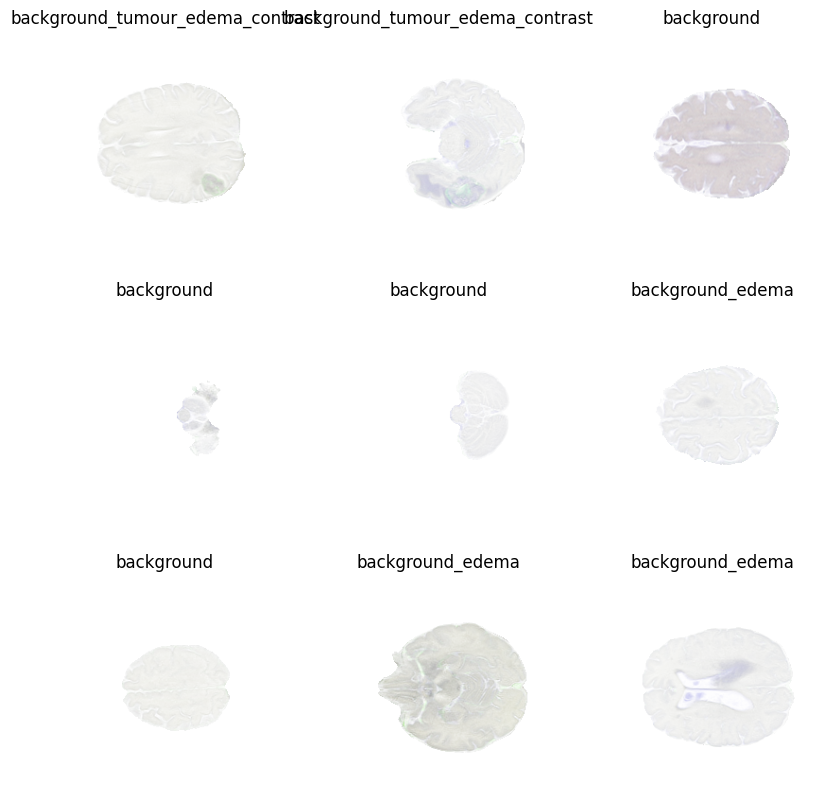

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 240, 240, 4)
(64,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./(2**8-1))

In [16]:
num_classes = len(class_names)

In [17]:

with strategy.scope():
    small_model = Sequential([
      layers.Rescaling(1./(2**8-1), input_shape=(img_height, img_width, 4)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])
    small_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

2022-11-22 18:48:19.043228: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-22 18:48:19.067078: I tensorflow/compiler/jit/xla_compilation_cache.cc:399] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-11-22 18:48:19.202738: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. RandomUniform


In [18]:
small_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 240, 4)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 16)      592       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [19]:
small_model_epochs=20
small_model_history = small_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=small_model_epochs,
  class_weight=class_weight
)

2022-11-22 18:48:20.651730: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39726
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
     

Epoch 1/20


2022-11-22 18:48:24.013881: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:263] Subgraph fingerprint:4934248457315733321
2022-11-22 18:48:24.104103: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-22 18:48:24.295080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-22 18:48:28.315308: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(9594418225973014184), session_name()


  3/621 [..............................] - ETA: 43s - loss: 1.2878 - accuracy: 0.3646   

2022-11-22 18:48:38.159422: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:180] Compilation of 9594418225973014184 with session name  took 9.844011835s and succeeded
2022-11-22 18:48:38.166902: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(9594418225973014184), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_4934248457315733321", property.function_library_fingerprint = 3570610554409558478, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,4,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-22 18:48:38.166948: I tensorflow/

 45/621 [=>............................] - ETA: 29s - loss: 1.4657 - accuracy: 0.3861

2022-11-22 18:48:40.456412: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(5908708446135417903), session_name()


 49/621 [=>............................] - ETA: 1:38 - loss: 1.5255 - accuracy: 0.3820

2022-11-22 18:48:46.294893: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:180] Compilation of 5908708446135417903 with session name  took 5.83840743s and succeeded
2022-11-22 18:48:46.300780: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(5908708446135417903), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_4934248457315733321", property.function_library_fingerprint = 3570610554409558478, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "6,240,240,4,;6,;6,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-22 18:48:46.300826: I tensorflow/c

620/621 [============================>.] - ETA: 0s - loss: 1.4051 - accuracy: 0.4613

2022-11-22 18:49:12.720365: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9931
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      

621/621 [==============================] - 69s 83ms/step - loss: 1.4071 - accuracy: 0.4615 - val_loss: 1.2925 - val_accuracy: 0.4816


2022-11-22 18:49:29.813979: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:180] Compilation of 14328982854514513469 with session name  took 2.635060255s and succeeded
2022-11-22 18:49:29.816231: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(14328982854514513469), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_14825175833020727167", property.function_library_fingerprint = 6376840749832048633, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "2,240,240,4,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-22 18:49:29.816288: I tensorflow/c

Epoch 2/20
621/621 [==============================] - 33s 53ms/step - loss: 1.1707 - accuracy: 0.5415 - val_loss: 0.9728 - val_accuracy: 0.6256
Epoch 3/20
621/621 [==============================] - 32s 52ms/step - loss: 0.8549 - accuracy: 0.6692 - val_loss: 0.8709 - val_accuracy: 0.6652
Epoch 4/20
621/621 [==============================] - 31s 51ms/step - loss: 0.6170 - accuracy: 0.7537 - val_loss: 0.6373 - val_accuracy: 0.7455
Epoch 5/20
621/621 [==============================] - 32s 51ms/step - loss: 0.4308 - accuracy: 0.8195 - val_loss: 0.4754 - val_accuracy: 0.8259
Epoch 6/20
621/621 [==============================] - 32s 51ms/step - loss: 0.2980 - accuracy: 0.8788 - val_loss: 0.5327 - val_accuracy: 0.8064
Epoch 7/20
621/621 [==============================] - 31s 50ms/step - loss: 0.2215 - accuracy: 0.9082 - val_loss: 0.5920 - val_accuracy: 0.7962
Epoch 8/20
621/621 [==============================] - 32s 51ms/step - loss: 0.1771 - accuracy: 0.9290 - val_loss: 0.4163 - val_accuracy:

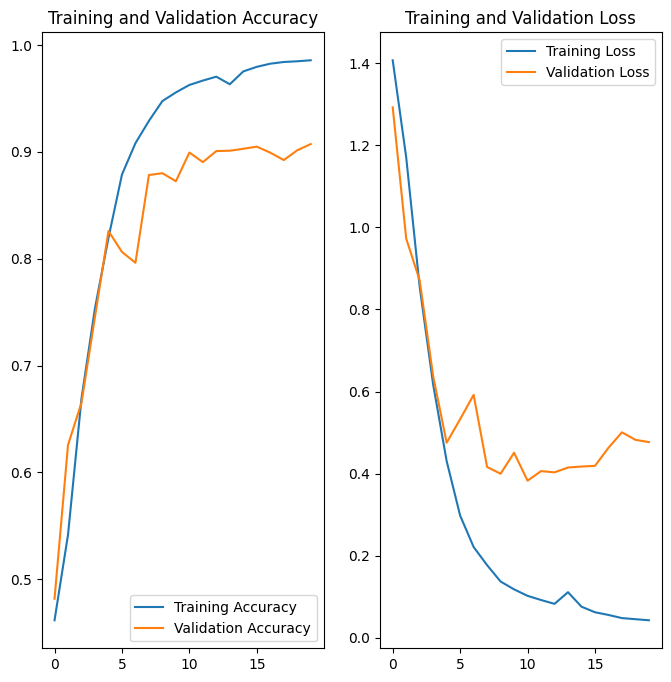

In [20]:
acc = small_model_history.history['accuracy']
val_acc = small_model_history.history['val_accuracy']

loss = small_model_history.history['loss']
val_loss = small_model_history.history['val_loss']

epochs_range = range(small_model_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:TPU_SYSTEM:0', device_type='TPU_SYSTEM'),
 PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]

In [22]:
with strategy.scope():
    larger_model = Sequential([
      layers.Rescaling(1./(2**8-1), input_shape=(img_height,
                                  img_width,
                                  4)),
      layers.Conv2D(8, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes, name="outputs")
    ])

    larger_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [23]:
larger_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 240, 240, 4)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 240, 240, 8)       296       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 120, 120, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 16)      1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)       

In [24]:
larger_model_epochs = 80
larger_model_history = larger_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=larger_model_epochs,
  class_weight=class_weight
)

2022-11-22 18:59:38.153286: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39726
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
     

Epoch 1/80


2022-11-22 18:59:41.455733: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:263] Subgraph fingerprint:3956565531356572082
2022-11-22 18:59:41.569398: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-22 18:59:41.784064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-22 18:59:42.012463: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(5986848433000685441), session_name()


  4/621 [..............................] - ETA: 29s - loss: 1.6043 - accuracy: 0.0938   

2022-11-22 18:59:46.076613: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:180] Compilation of 5986848433000685441 with session name  took 4.064069743s and succeeded
2022-11-22 18:59:46.085030: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(5986848433000685441), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_3956565531356572082", property.function_library_fingerprint = 10106570721347727073, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,4,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-22 18:59:46.085069: I tensorflow

611/621 [============================>.] - ETA: 0s - loss: 1.4543 - accuracy: 0.4304

2022-11-22 19:00:10.512523: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(3816095277355975261), session_name()


616/621 [============================>.] - ETA: 0s - loss: 1.4555 - accuracy: 0.4303

2022-11-22 19:00:14.179824: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:180] Compilation of 3816095277355975261 with session name  took 3.667186502s and succeeded
2022-11-22 19:00:14.188039: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(3816095277355975261), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_3956565531356572082", property.function_library_fingerprint = 10106570721347727073, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "6,240,240,4,;6,;6,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-22 19:00:14.188080: I tensorflow

620/621 [============================>.] - ETA: 0s - loss: 1.4602 - accuracy: 0.4295

2022-11-22 19:00:14.590258: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9931
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      

621/621 [==============================] - 46s 62ms/step - loss: 1.4596 - accuracy: 0.4293 - val_loss: 1.3721 - val_accuracy: 0.3238


2022-11-22 19:00:24.733249: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:180] Compilation of 16688000418961301218 with session name  took 2.135004936s and succeeded
2022-11-22 19:00:24.736118: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(16688000418961301218), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_8126239656553869918", property.function_library_fingerprint = 7746148971398162145, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "2,240,240,4,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-22 19:00:24.736155: I tensorflow/co

Epoch 2/80
621/621 [==============================] - 30s 48ms/step - loss: 1.3575 - accuracy: 0.5383 - val_loss: 0.9098 - val_accuracy: 0.6704
Epoch 3/80
621/621 [==============================] - 31s 50ms/step - loss: 1.2398 - accuracy: 0.5541 - val_loss: 0.8035 - val_accuracy: 0.7136
Epoch 4/80
621/621 [==============================] - 30s 48ms/step - loss: 1.0337 - accuracy: 0.6703 - val_loss: 0.7490 - val_accuracy: 0.7272
Epoch 5/80
621/621 [==============================] - 30s 48ms/step - loss: 0.9325 - accuracy: 0.6826 - val_loss: 0.7826 - val_accuracy: 0.7124
Epoch 6/80
621/621 [==============================] - 30s 49ms/step - loss: 0.8768 - accuracy: 0.6937 - val_loss: 0.6396 - val_accuracy: 0.7389
Epoch 7/80
621/621 [==============================] - 30s 48ms/step - loss: 0.7941 - accuracy: 0.7029 - val_loss: 0.6587 - val_accuracy: 0.7471
Epoch 8/80
621/621 [==============================] - 30s 48ms/step - loss: 0.7604 - accuracy: 0.7070 - val_loss: 0.6153 - val_accuracy:

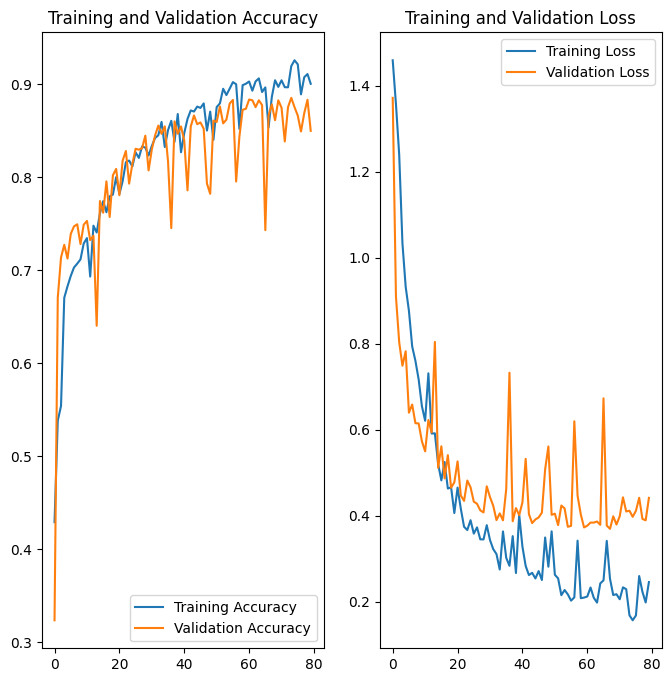

In [25]:
acc = larger_model_history.history['accuracy']
val_acc = larger_model_history.history['val_accuracy']

loss = larger_model_history.history['loss']
val_loss = larger_model_history.history['val_loss']

epochs_range = range(larger_model_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  4)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)



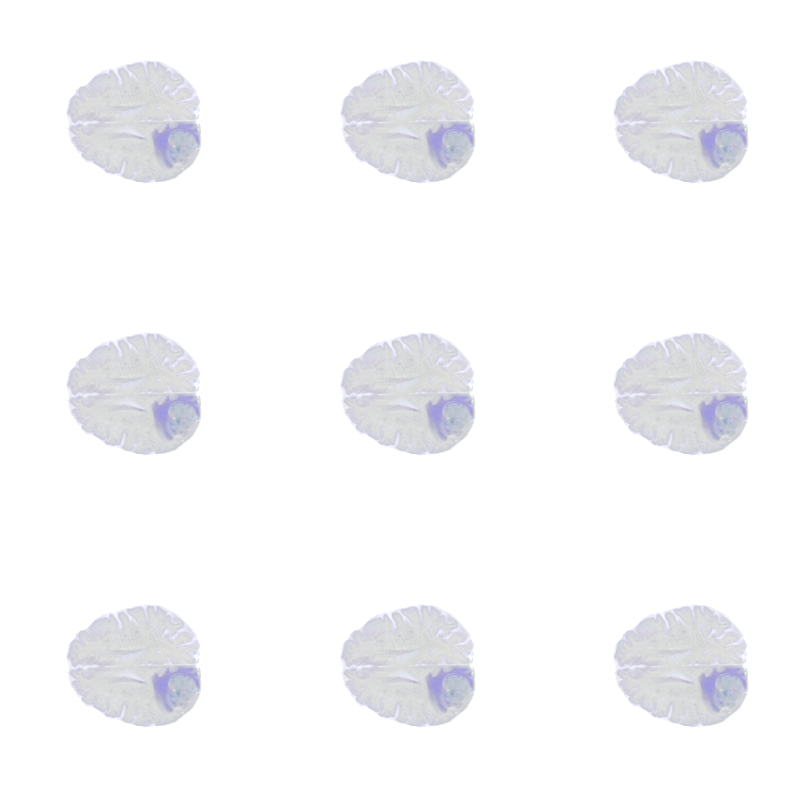

In [37]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    #with tf.device('/CPU:0'):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [28]:
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
aug_ds = aug_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


In [31]:
with strategy.scope():
    augmented_model = Sequential([
      layers.Rescaling(1./(2**8-1), input_shape=(img_height,
                                  img_width,
                                  4)),
      layers.Conv2D(8, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes, name="outputs")
    ])

    augmented_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [32]:
augmented_model_epochs = 200
augmented_model_history = augmented_model.fit(
  aug_ds,
  validation_data=val_ds,
  epochs=augmented_model_epochs,
  class_weight=class_weight
)

2022-11-22 20:12:38.612635: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39726
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
     

Epoch 1/200


2022-11-22 20:12:41.881252: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:263] Subgraph fingerprint:15880288671816224732
2022-11-22 20:12:42.001660: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-22 20:12:42.222344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-22 20:12:42.463745: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(15564525051247385304), session_name()


  3/621 [..............................] - ETA: 24s - loss: 1.4148 - accuracy: 0.3750    

2022-11-22 20:12:46.203387: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:180] Compilation of 15564525051247385304 with session name  took 3.739546574s and succeeded
2022-11-22 20:12:46.211832: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(15564525051247385304), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_15880288671816224732", property.function_library_fingerprint = 17892209179719506294, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,4,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-22 20:12:46.211884: I tensorf

222/621 [=========>....................] - ETA: 15s - loss: 1.4671 - accuracy: 0.4201

2022-11-22 20:12:55.164692: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(13681158725133056722), session_name()


226/621 [=========>....................] - ETA: 22s - loss: 1.4732 - accuracy: 0.4225

2022-11-22 20:12:58.966438: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:180] Compilation of 13681158725133056722 with session name  took 3.80163903s and succeeded
2022-11-22 20:12:58.974187: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(13681158725133056722), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_15880288671816224732", property.function_library_fingerprint = 17892209179719506294, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "6,240,240,4,;6,;6,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-22 20:12:58.974225: I tensorfl

620/621 [============================>.] - ETA: 0s - loss: 1.4474 - accuracy: 0.4384

2022-11-22 20:13:14.961779: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9931
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      

621/621 [==============================] - 46s 63ms/step - loss: 1.4470 - accuracy: 0.4382 - val_loss: 1.3284 - val_accuracy: 0.3650


2022-11-22 20:13:25.484042: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:180] Compilation of 189676207925814194 with session name  took 2.176258012s and succeeded
2022-11-22 20:13:25.487268: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(189676207925814194), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_3066114000581080089", property.function_library_fingerprint = 83464770414538469, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "2,240,240,4,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-22 20:13:25.487308: I tensorflow/core/tpu

Epoch 2/200
621/621 [==============================] - 30s 48ms/step - loss: 1.3285 - accuracy: 0.5634 - val_loss: 1.0135 - val_accuracy: 0.6598
Epoch 3/200
621/621 [==============================] - 30s 48ms/step - loss: 1.1671 - accuracy: 0.6490 - val_loss: 0.8259 - val_accuracy: 0.7063
Epoch 4/200
621/621 [==============================] - 30s 48ms/step - loss: 1.0815 - accuracy: 0.6686 - val_loss: 0.9309 - val_accuracy: 0.6524
Epoch 5/200
621/621 [==============================] - 30s 48ms/step - loss: 1.0521 - accuracy: 0.6726 - val_loss: 0.7898 - val_accuracy: 0.6961
Epoch 6/200
621/621 [==============================] - 29s 47ms/step - loss: 0.9997 - accuracy: 0.6747 - val_loss: 0.7046 - val_accuracy: 0.7031
Epoch 7/200
621/621 [==============================] - 30s 48ms/step - loss: 0.9945 - accuracy: 0.6697 - val_loss: 0.7436 - val_accuracy: 0.6951
Epoch 8/200
621/621 [==============================] - 30s 49ms/step - loss: 0.9821 - accuracy: 0.6727 - val_loss: 0.7783 - val_ac

KeyboardInterrupt: 

In [33]:
acc = augmented_model_history.history['accuracy']
val_acc = augmented_model_history.history['val_accuracy']

loss = augmented_model_history.history['loss']
val_loss = augmented_model_history.history['val_loss']

epochs_range = range(augmented_model_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'augmented_model_history' is not defined